In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import joblib

import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

def analyze_images(root_dir):
    """Analyzes images in subdirectories and returns a DataFrame."""

    data = []
    for split in ['train', 'test']:
        split_dir = os.path.join(root_dir, split)
        for emotion in os.listdir(split_dir):
            emotion_dir = os.path.join(split_dir, emotion)
            for image_file in os.listdir(emotion_dir):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if it's an image
                    image_path = os.path.join(emotion_dir, image_file)
                    try:
                        img = cv2.imread(image_path)
                        if img is None:
                            print(f"Warning: Could not read image {image_path}")
                            continue  # Skip to the next image if reading fails
                        height, width, channels = img.shape
                        size = (width, height)
                        aspect_ratio = width / height
                        is_grayscale = (channels == 1)
                        mean_pixel_value = np.mean(img) #Mean pixel value
                        std_pixel_value = np.std(img) #Standard deviation of pixel values
                        min_pixel_value = np.min(img)
                        max_pixel_value = np.max(img)
                        data.append({
                            'split': split,
                            'emotion': emotion,
                            'file_name': image_file,
                            'size': size,
                            'aspect_ratio': aspect_ratio,
                            'channels': channels,
                            'is_grayscale': is_grayscale,
                            'mean_pixel_value': mean_pixel_value,
                            'std_pixel_value': std_pixel_value,
                            'min_pixel_value': min_pixel_value,
                            'max_pixel_value': max_pixel_value,
                        })
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")

    return pd.DataFrame(data)

# Example usage (replace with your root directory)
root_directory = './dataset_emociones'  # Assuming the script is in the same directory as 'train' and 'test'
df = analyze_images(root_directory)

# Data analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15339 entries, 0 to 15338
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   split             15339 non-null  object 
 1   emotion           15339 non-null  object 
 2   file_name         15339 non-null  object 
 3   size              15339 non-null  object 
 4   aspect_ratio      15339 non-null  float64
 5   channels          15339 non-null  int64  
 6   is_grayscale      15339 non-null  bool   
 7   mean_pixel_value  15339 non-null  float64
 8   std_pixel_value   15339 non-null  float64
 9   min_pixel_value   15339 non-null  uint8  
 10  max_pixel_value   15339 non-null  uint8  
dtypes: bool(1), float64(3), int64(1), object(4), uint8(2)
memory usage: 1003.8+ KB


In [9]:
df.describe()

,aspect_ratio,channels,mean_pixel_value,std_pixel_value,min_pixel_value,max_pixel_value
count,15339.0,15339.0,15339.000000,15339.000000,15339.000000,15339.000000
mean,1.0,3.0,121.213288,55.114700,2.365734,243.348328
std,0.0,0.0,34.293184,13.668618,8.139129,23.073971
min,1.0,3.0,11.897433,6.621224,0.000000,40.000000
25%,1.0,3.0,97.069767,45.554805,0.000000,242.000000
50%,1.0,3.0,121.150100,54.455721,0.000000,255.000000
75%,1.0,3.0,145.483067,64.035642,0.000000,255.000000
max,1.0,3.0,236.206300,113.259548,169.000000,255.000000


In [10]:
df.head()

,split,emotion,file_name,size,aspect_ratio,channels,is_grayscale,mean_pixel_value,std_pixel_value,min_pixel_value,max_pixel_value
0,train,alegria,train_00003_aligned.jpg,"(100, 100)",1.0,3,False,152.753333,83.768101,0,255
1,train,alegria,train_00004_aligned.jpg,"(100, 100)",1.0,3,False,173.105500,76.814304,0,255
2,train,alegria,train_00008_aligned.jpg,"(100, 100)",1.0,3,False,121.993400,60.041547,3,255
3,train,alegria,train_00009_aligned.jpg,"(100, 100)",1.0,3,False,98.030200,45.078688,0,247
4,train,alegria,train_00011_aligned.jpg,"(100, 100)",1.0,3,False,73.018367,48.698960,0,255


In [14]:
print(df['size'].unique())
print(df['channels'].unique())
print(df['aspect_ratio'].unique())

[(100, 100)]
[3]
[1.]


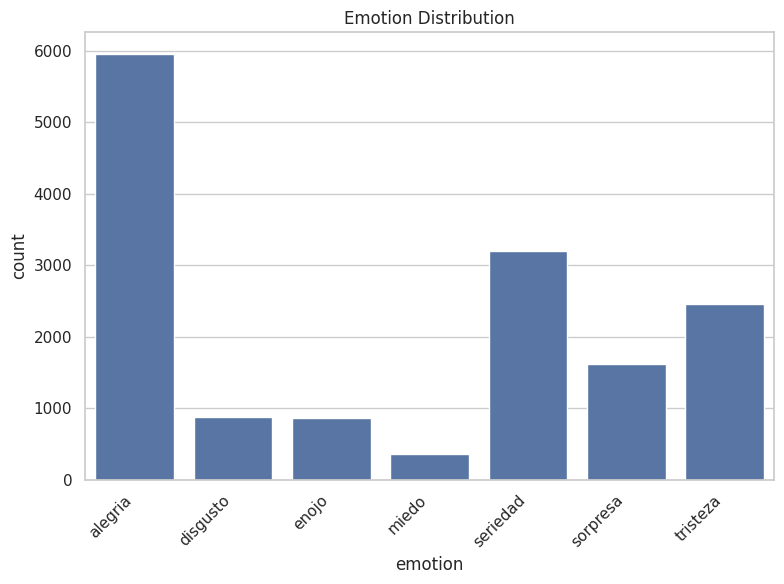

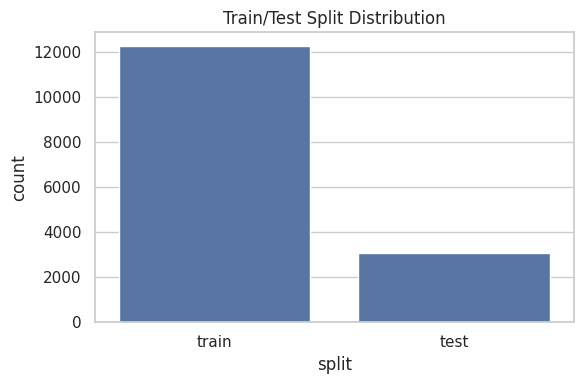

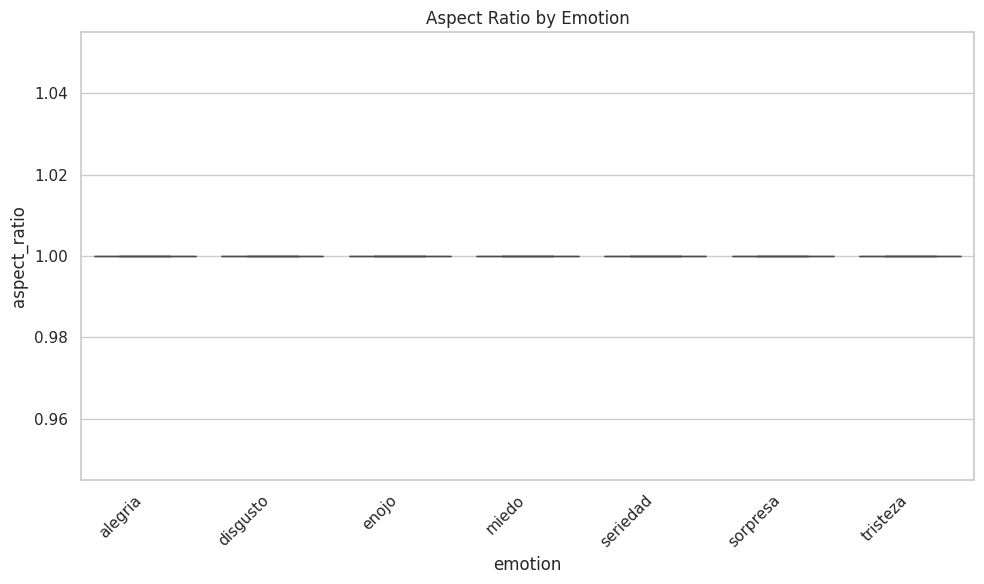

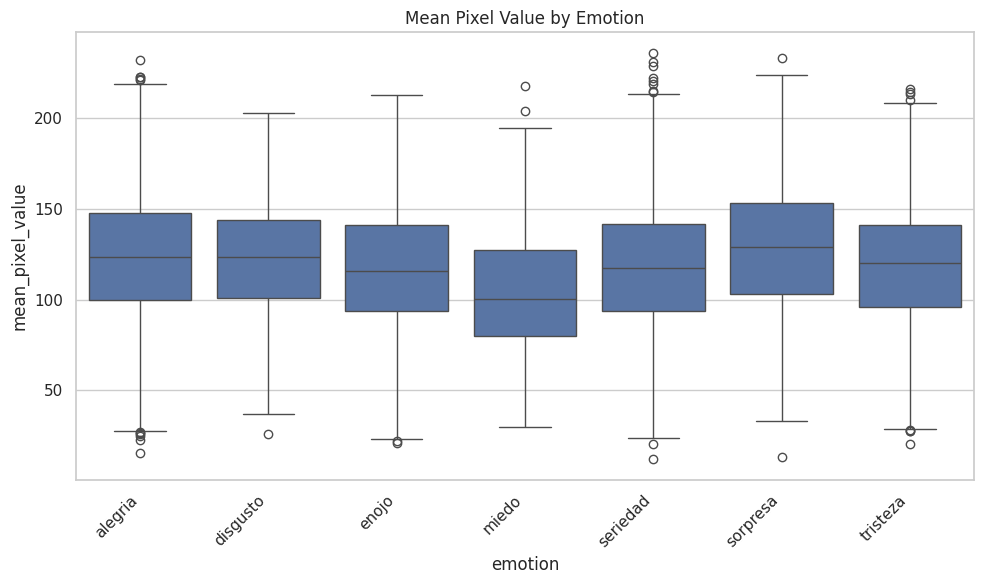

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data_analysis(df):
    """Plots data analysis using Seaborn."""

    sns.set(style="whitegrid")  # Set Seaborn style

    plt.figure(figsize=(8, 6))
    sns.countplot(x='emotion', data=df)
    plt.title('Emotion Distribution')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.countplot(x='split', data=df)
    plt.title('Train/Test Split Distribution')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='emotion', y='aspect_ratio', data=df)
    plt.title('Aspect Ratio by Emotion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='emotion', y='mean_pixel_value', data=df)
    plt.title('Mean Pixel Value by Emotion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    plt.show()

# Assuming 'df' is your DataFrame from the previous code
plot_data_analysis(df)

# Classification

Para el diseño de la arquitectura de nuestra CNN analizamos un [review paper][1] del año 2016 que analiza y compara seis trabajos ([3][3], [4][4], [5][5], [6][6], [7][7], [8][8]) de reconocimiento de expreciones faciales (FER) aplicados al dataset [FER2013][2]. Se tratan la arquitectura, preprocesamiento, y entrenamiento de todas las arquitecturas mencionadas.

Preprocesamiento:  [3][3] normaliza todas las imagenes, [5][5] aplica tecnicas para mejorar el contraste (histogram equalization, linear plane fitting). Tambien se mencionan preprocesamientos relacionados a face cropping y a landmark detection para corregir imagenes en que el rostro aparece lejano u obstruido por otro objeto. Como nuetro caso no presenta dichos problemas se obviaran estos preprocesamientos.



[1]: <https://arxiv.org/abs/1612.02903> "Facial Expression Recognition using Convolutional Neural Networks: State of the Art" 

[2]: <https://arxiv.org/abs/1307.0414> "Challenges in representation learning: A report on three machine learning contests”

[3]: (7) <> "Deep Learning using Support Vector Machines"

[4]: (11) <> "Hierarchical committee of deep convolutional neural networks for robust facial expression recognition"

[5]: (8) <> "Image based static facial expression recognition with multiple deep network learning"

[6]: (12) <> "Going Deeper in Facial Expression Recognition using Deep Neural Networks"

[7]: (14) <> "Learning Social Relation Traits from Face Images"

[8]: (9) <> "Using Aligned and Non-Aligned Face Information for Automatic Affect Recognition in the Wild: A Deep Learning Approach,"

In [19]:
from models import *

Epoch 1, Loss: 1.7846071698392432
Epoch 2, Loss: 1.3481838158331811
Epoch 3, Loss: 1.0668674963526428
Epoch 4, Loss: 0.8726779233353833
Epoch 5, Loss: 0.7181159233053526
Epoch 6, Loss: 0.6107174612504119
Epoch 7, Loss: 0.5166741547485193
Epoch 8, Loss: 0.4415518283494748
Epoch 9, Loss: 0.37953223375370726
Epoch 10, Loss: 0.3576841834001243
              precision    recall  f1-score   support

     alegria       0.97      0.88      0.92      4772
    disgusto       0.74      0.99      0.85       717
       enojo       0.91      0.99      0.95       705
       miedo       0.92      1.00      0.96       281
    seriedad       0.84      0.85      0.85      2524
    sorpresa       0.91      0.97      0.94      1290
    tristeza       0.85      0.86      0.85      1982

    accuracy                           0.89     12271
   macro avg       0.88      0.93      0.90     12271
weighted avg       0.90      0.89      0.89     12271



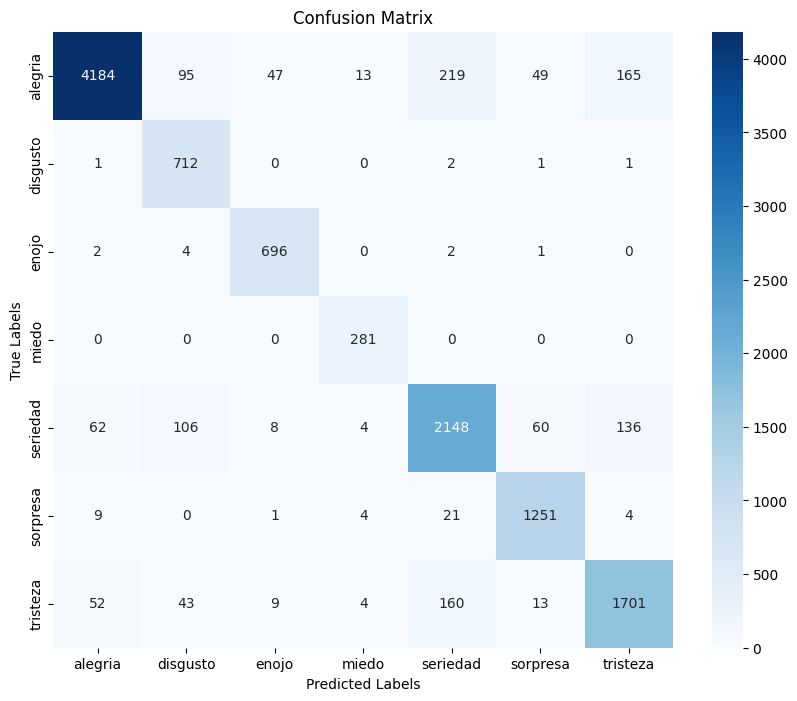

In [11]:
# Example usage
root_directory = './dataset_emociones'
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(root_directory, transform, split='train')
test_dataset = ImageDataset(root_directory, transform, split='train') #for test, change to test.

num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
cnn_builder = EmotionCNNBuilder(num_classes)

classifier = NnClassifier(cnn_builder)
classifier.fit(train_dataset)

predictions = classifier.predict(test_dataset)

emotion_labels = os.listdir(os.path.join(root_directory, 'train'))
true_labels = test_dataset.labels
print(classification_report(true_labels, predictions, target_names=emotion_labels))

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [91]:
torch.cuda.empty_cache()

Loading weights from CPCPFF.pth


Loaded training history from CPCPFF_history.csv


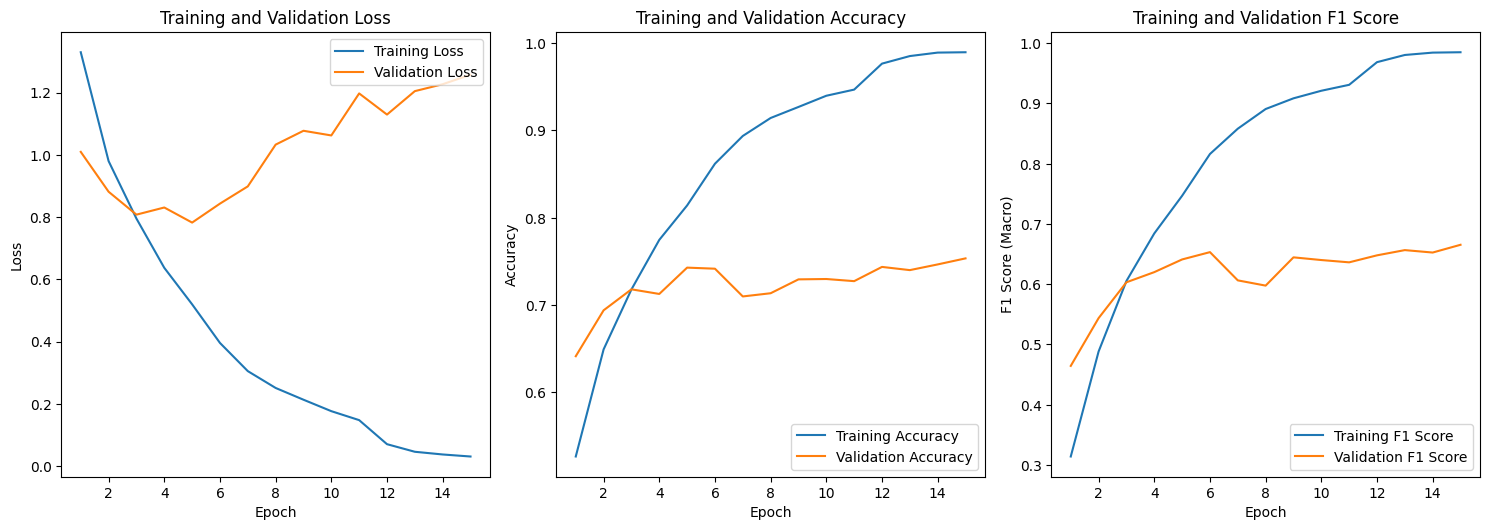

              precision    recall  f1-score   support

     alegria       0.97      0.98      0.98      4772
    disgusto       0.93      0.88      0.90       717
       enojo       0.93      0.92      0.93       705
       miedo       0.94      0.90      0.92       281
    seriedad       0.93      0.95      0.94      2524
    sorpresa       0.96      0.95      0.96      1290
    tristeza       0.93      0.93      0.93      1982

    accuracy                           0.95     12271
   macro avg       0.94      0.93      0.94     12271
weighted avg       0.95      0.95      0.95     12271



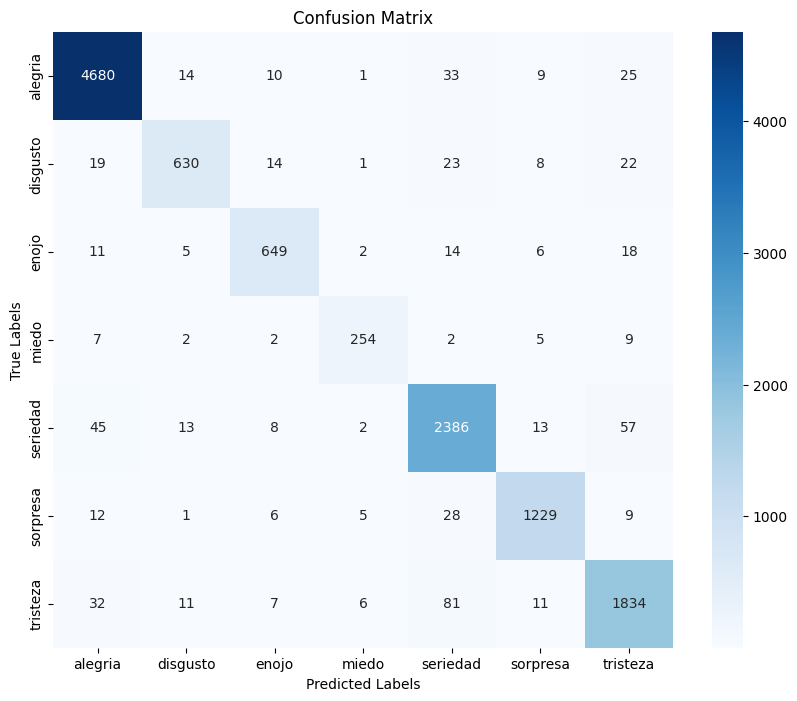

In [15]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPFF",num_classes)
eval_model(model, root_directory, save_path="CPCPFF.pth")
# eval_model(model, root_directory, save_path=None)

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.4087, Training Acc: 0.4850, Training F1: 0.2550


Epoch 1, Validation Loss: 1.1351, Validation Acc: 0.5988, Validation F1: 0.3985


Epoch 2, Training Loss: 1.0469, Training Acc: 0.6310, Training F1: 0.4580


Epoch 2, Validation Loss: 0.8911, Validation Acc: 0.6790, Validation F1: 0.5247


Epoch 3, Training Loss: 0.8570, Training Acc: 0.6978, Training F1: 0.5685


Epoch 3, Validation Loss: 0.8504, Validation Acc: 0.6969, Validation F1: 0.5310


Epoch 4, Training Loss: 0.7197, Training Acc: 0.7445, Training F1: 0.6394


Epoch 4, Validation Loss: 0.7528, Validation Acc: 0.7283, Validation F1: 0.6078


Epoch 5, Training Loss: 0.6063, Training Acc: 0.7873, Training F1: 0.7061


Epoch 5, Validation Loss: 0.7834, Validation Acc: 0.7446, Validation F1: 0.6155


Epoch 6, Training Loss: 0.4900, Training Acc: 0.8252, Training F1: 0.7609


Epoch 6, Validation Loss: 0.7856, Validation Acc: 0.7393, Validation F1: 0.6188


Epoch 7, Training Loss: 0.4021, Training Acc: 0.8577, Training F1: 0.7980


Epoch 7, Validation Loss: 0.8068, Validation Acc: 0.7462, Validation F1: 0.6306


Epoch 8, Training Loss: 0.3270, Training Acc: 0.8846, Training F1: 0.8387


Epoch 8, Validation Loss: 0.8649, Validation Acc: 0.7519, Validation F1: 0.6508


Epoch 9, Training Loss: 0.2639, Training Acc: 0.9105, Training F1: 0.8779


Epoch 9, Validation Loss: 0.8439, Validation Acc: 0.7572, Validation F1: 0.6624


Epoch 10, Training Loss: 0.2163, Training Acc: 0.9221, Training F1: 0.8973


Epoch 10, Validation Loss: 0.9144, Validation Acc: 0.7536, Validation F1: 0.6462


Epoch 11, Training Loss: 0.0973, Training Acc: 0.9665, Training F1: 0.9533


Epoch 11, Validation Loss: 1.0263, Validation Acc: 0.7613, Validation F1: 0.6509


Epoch 12, Training Loss: 0.0541, Training Acc: 0.9823, Training F1: 0.9778


Epoch 12, Validation Loss: 1.1171, Validation Acc: 0.7678, Validation F1: 0.6691


Epoch 13, Training Loss: 0.0485, Training Acc: 0.9839, Training F1: 0.9777


Epoch 13, Validation Loss: 1.1339, Validation Acc: 0.7670, Validation F1: 0.6771


Epoch 14, Training Loss: 0.0374, Training Acc: 0.9880, Training F1: 0.9842


Epoch 14, Validation Loss: 1.1546, Validation Acc: 0.7650, Validation F1: 0.6576
Early stopping triggered (validation loss did not improve for 10 epochs).
Model weights saved to CPCPCPFF.pth
Training history saved to CPCPCPFF_history.csv


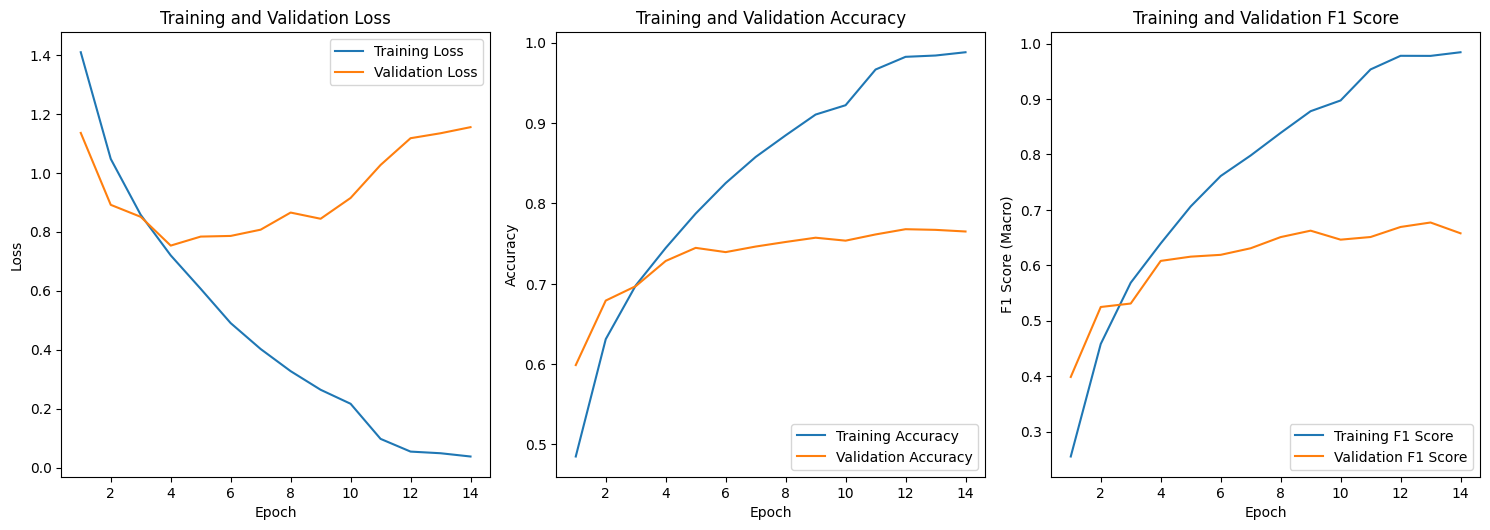

              precision    recall  f1-score   support

     alegria       0.98      0.98      0.98      4772
    disgusto       0.92      0.88      0.90       717
       enojo       0.94      0.94      0.94       705
       miedo       0.97      0.85      0.91       281
    seriedad       0.92      0.96      0.94      2524
    sorpresa       0.96      0.95      0.95      1290
    tristeza       0.95      0.92      0.93      1982

    accuracy                           0.95     12271
   macro avg       0.95      0.93      0.94     12271
weighted avg       0.95      0.95      0.95     12271



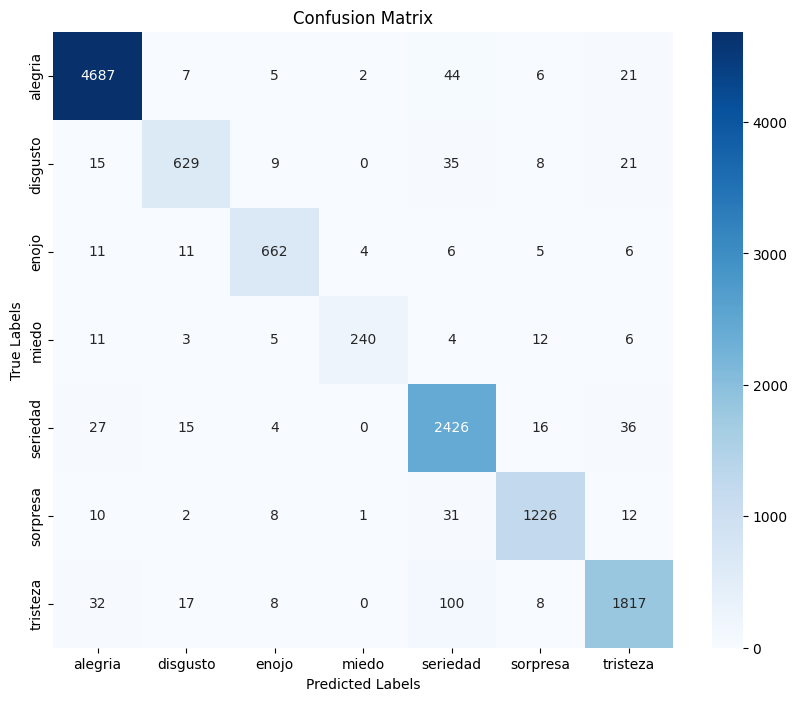

In [16]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPCPFF",num_classes)
eval_model(model, root_directory, save_path="CPCPCPFF.pth")

Loading weights from PCCPCCPCFFF.pth


Loaded training history from PCCPCCPCFFF_history.csv


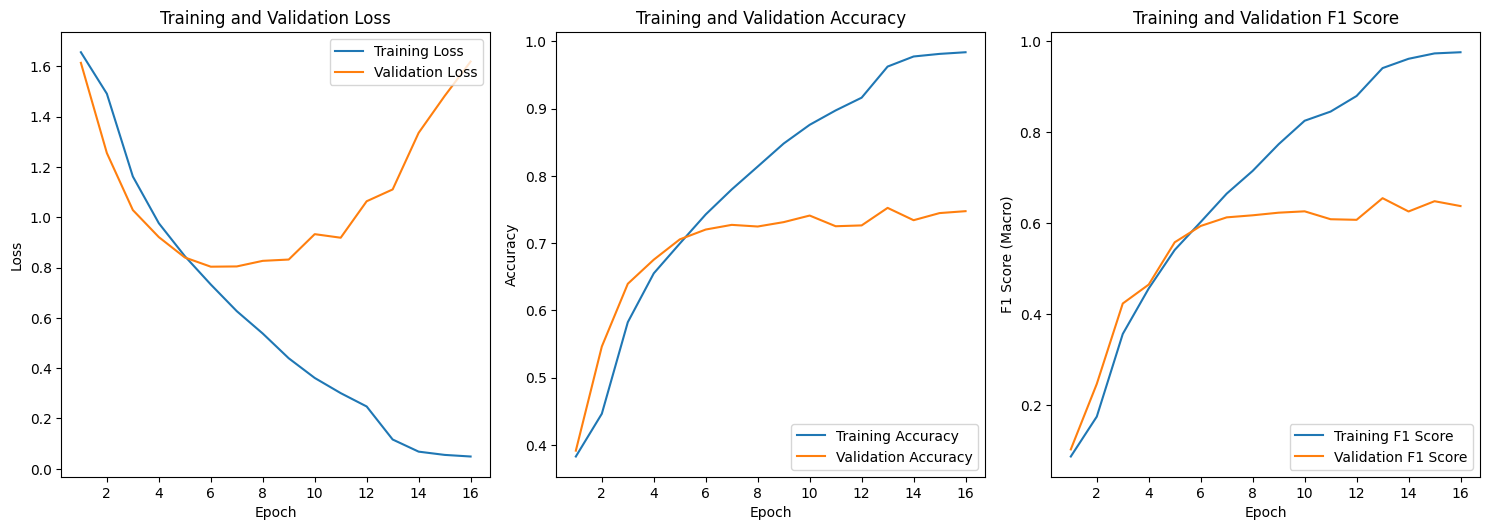

              precision    recall  f1-score   support

     alegria       0.98      0.98      0.98      4772
    disgusto       0.91      0.87      0.89       717
       enojo       0.97      0.90      0.93       705
       miedo       0.95      0.88      0.91       281
    seriedad       0.90      0.96      0.93      2524
    sorpresa       0.94      0.94      0.94      1290
    tristeza       0.95      0.92      0.94      1982

    accuracy                           0.95     12271
   macro avg       0.94      0.92      0.93     12271
weighted avg       0.95      0.95      0.95     12271



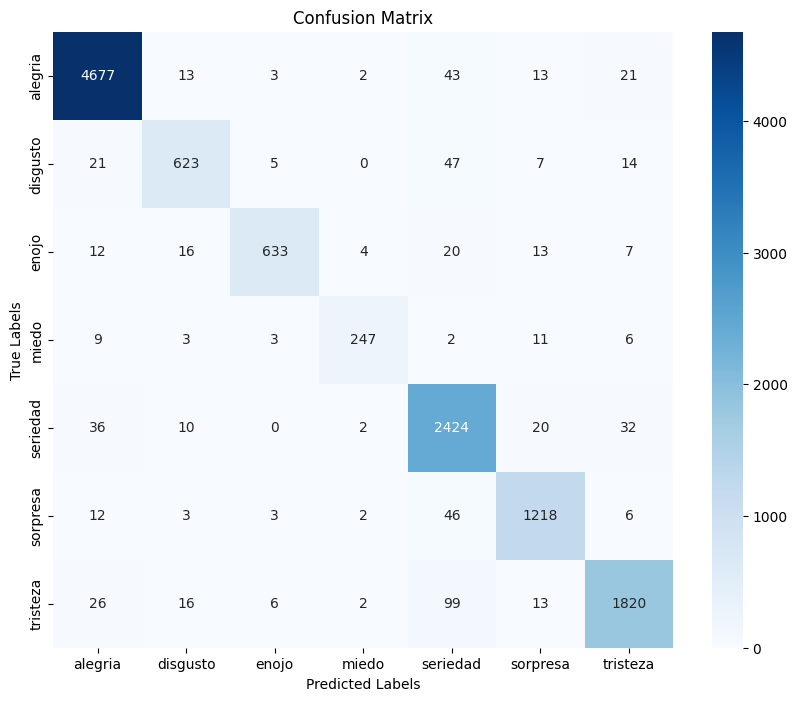

In [20]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("PCCPCCPCFFF",num_classes)
eval_model(model, root_directory, "PCCPCCPCFFF.pth")

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.6502, Training Acc: 0.3880, Training F1: 0.0862


Epoch 1, Validation Loss: 1.5890, Validation Acc: 0.3988, Validation F1: 0.1184


Epoch 2, Training Loss: 1.4584, Training Acc: 0.4669, Training F1: 0.2015


Epoch 2, Validation Loss: 1.2604, Validation Acc: 0.5605, Validation F1: 0.3061


Epoch 3, Training Loss: 1.1758, Training Acc: 0.5767, Training F1: 0.3478


Epoch 3, Validation Loss: 1.0100, Validation Acc: 0.6489, Validation F1: 0.4190


Epoch 4, Training Loss: 0.9821, Training Acc: 0.6538, Training F1: 0.4651


Epoch 4, Validation Loss: 0.9331, Validation Acc: 0.6692, Validation F1: 0.4990


Epoch 5, Training Loss: 0.8487, Training Acc: 0.7048, Training F1: 0.5572


Epoch 5, Validation Loss: 0.8607, Validation Acc: 0.7075, Validation F1: 0.5553


Epoch 6, Training Loss: 0.7518, Training Acc: 0.7329, Training F1: 0.6014


Epoch 6, Validation Loss: 0.8421, Validation Acc: 0.7104, Validation F1: 0.5678


Epoch 7, Training Loss: 0.6453, Training Acc: 0.7751, Training F1: 0.6732


Epoch 7, Validation Loss: 0.7794, Validation Acc: 0.7312, Validation F1: 0.6043


Epoch 8, Training Loss: 0.5409, Training Acc: 0.8046, Training F1: 0.7194


Epoch 8, Validation Loss: 0.8188, Validation Acc: 0.7405, Validation F1: 0.5876


Epoch 9, Training Loss: 0.4450, Training Acc: 0.8499, Training F1: 0.7787


Epoch 9, Validation Loss: 0.8526, Validation Acc: 0.7320, Validation F1: 0.6068


Epoch 10, Training Loss: 0.3491, Training Acc: 0.8814, Training F1: 0.8268


Epoch 10, Validation Loss: 0.9114, Validation Acc: 0.7470, Validation F1: 0.6059


Epoch 11, Training Loss: 0.3115, Training Acc: 0.8919, Training F1: 0.8402


Epoch 11, Validation Loss: 0.8594, Validation Acc: 0.7303, Validation F1: 0.5860


Epoch 12, Training Loss: 0.2514, Training Acc: 0.9150, Training F1: 0.8735


Epoch 12, Validation Loss: 0.9984, Validation Acc: 0.7206, Validation F1: 0.5758


Epoch 13, Training Loss: 0.1954, Training Acc: 0.9336, Training F1: 0.9005


Epoch 13, Validation Loss: 0.9483, Validation Acc: 0.7381, Validation F1: 0.6275


Epoch 14, Training Loss: 0.0978, Training Acc: 0.9684, Training F1: 0.9515


Epoch 14, Validation Loss: 1.2675, Validation Acc: 0.7487, Validation F1: 0.6140


Epoch 15, Training Loss: 0.0768, Training Acc: 0.9760, Training F1: 0.9636


Epoch 15, Validation Loss: 1.2758, Validation Acc: 0.7621, Validation F1: 0.6393


Epoch 16, Training Loss: 0.0465, Training Acc: 0.9861, Training F1: 0.9767


Epoch 16, Validation Loss: 1.4538, Validation Acc: 0.7487, Validation F1: 0.6336


Epoch 17, Training Loss: 0.0455, Training Acc: 0.9852, Training F1: 0.9753


Epoch 17, Validation Loss: 1.3530, Validation Acc: 0.7507, Validation F1: 0.6210
Early stopping triggered (validation loss did not improve for 10 epochs).


Model weights saved to CPCPIIPIPFFF.pth
Training history saved to CPCPIIPIPFFF_history.csv


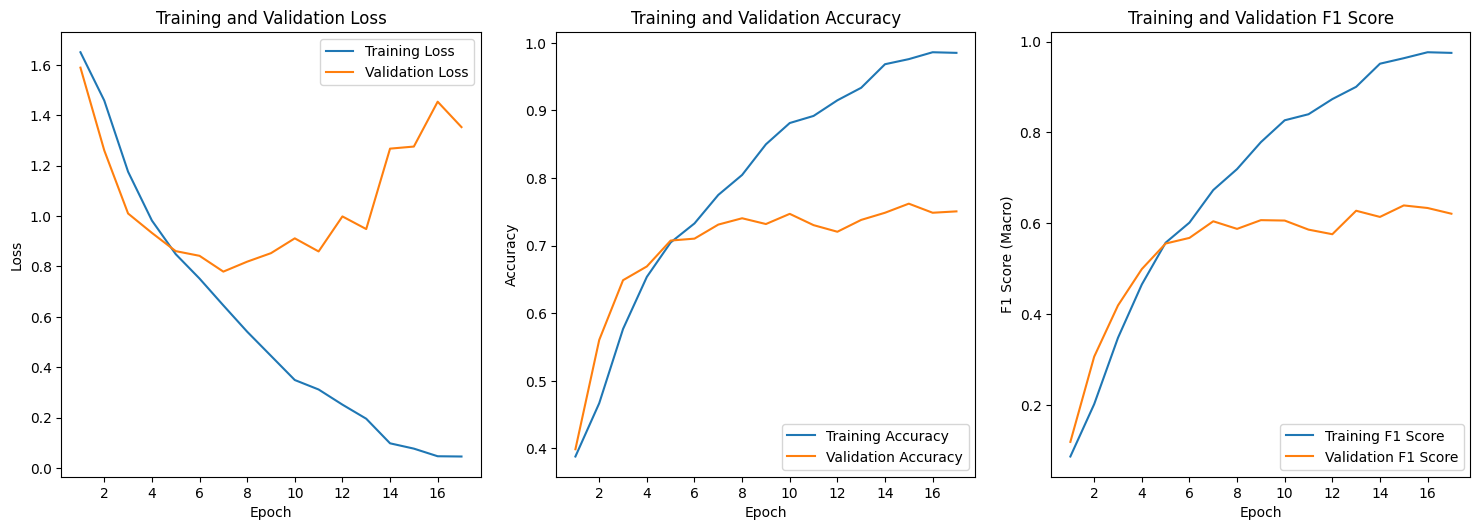

              precision    recall  f1-score   support

     alegria       0.97      0.98      0.98      4772
    disgusto       0.93      0.85      0.89       717
       enojo       0.94      0.93      0.94       705
       miedo       0.96      0.85      0.90       281
    seriedad       0.93      0.95      0.94      2524
    sorpresa       0.96      0.94      0.95      1290
    tristeza       0.93      0.93      0.93      1982

    accuracy                           0.95     12271
   macro avg       0.95      0.92      0.93     12271
weighted avg       0.95      0.95      0.95     12271



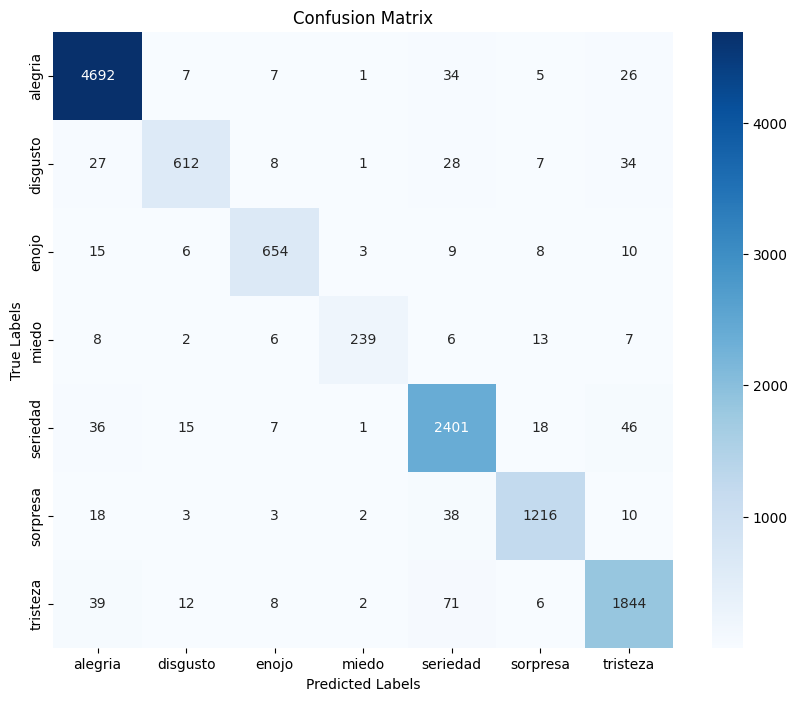

In [19]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPIIPIPFFF",num_clas2ses)
eval_model(model, root_directory, "CPCPIIPIPFFF.pth")

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.2705, Training Acc: 0.5365, Training F1: 0.3214


Epoch 1, Validation Loss: 1.0376, Validation Acc: 0.6253, Validation F1: 0.4314


Epoch 2, Training Loss: 0.9360, Training Acc: 0.6613, Training F1: 0.5106


Epoch 2, Validation Loss: 0.8767, Validation Acc: 0.6925, Validation F1: 0.5339


Epoch 3, Training Loss: 0.7649, Training Acc: 0.7267, Training F1: 0.6057


Epoch 3, Validation Loss: 0.8471, Validation Acc: 0.7149, Validation F1: 0.5723


Epoch 4, Training Loss: 0.6057, Training Acc: 0.7813, Training F1: 0.6898


Epoch 4, Validation Loss: 0.8232, Validation Acc: 0.7303, Validation F1: 0.5944


Epoch 5, Training Loss: 0.4768, Training Acc: 0.8315, Training F1: 0.7617


Epoch 5, Validation Loss: 0.8501, Validation Acc: 0.7295, Validation F1: 0.5964


Epoch 6, Training Loss: 0.3480, Training Acc: 0.8762, Training F1: 0.8247


Epoch 6, Validation Loss: 0.8551, Validation Acc: 0.7495, Validation F1: 0.6305


Epoch 7, Training Loss: 0.2462, Training Acc: 0.9122, Training F1: 0.8774


Epoch 7, Validation Loss: 0.9325, Validation Acc: 0.7409, Validation F1: 0.6218


Epoch 8, Training Loss: 0.2002, Training Acc: 0.9324, Training F1: 0.9115


Epoch 8, Validation Loss: 0.9598, Validation Acc: 0.7385, Validation F1: 0.6079


Epoch 9, Training Loss: 0.1557, Training Acc: 0.9459, Training F1: 0.9271


Epoch 9, Validation Loss: 1.1058, Validation Acc: 0.7352, Validation F1: 0.6185


Epoch 10, Training Loss: 0.1292, Training Acc: 0.9555, Training F1: 0.9413


Epoch 10, Validation Loss: 1.1017, Validation Acc: 0.7418, Validation F1: 0.6286


Epoch 11, Training Loss: 0.0392, Training Acc: 0.9877, Training F1: 0.9839


Epoch 11, Validation Loss: 1.2824, Validation Acc: 0.7593, Validation F1: 0.6359


Epoch 12, Training Loss: 0.0181, Training Acc: 0.9944, Training F1: 0.9925


Epoch 12, Validation Loss: 1.3728, Validation Acc: 0.7633, Validation F1: 0.6423


Epoch 13, Training Loss: 0.0125, Training Acc: 0.9959, Training F1: 0.9922


Epoch 13, Validation Loss: 1.4299, Validation Acc: 0.7654, Validation F1: 0.6443


Epoch 14, Training Loss: 0.0116, Training Acc: 0.9966, Training F1: 0.9947


Epoch 14, Validation Loss: 1.3853, Validation Acc: 0.7633, Validation F1: 0.6486
Early stopping triggered (validation loss did not improve for 10 epochs).


Model weights saved to CPNCPNCPCFF.pth
Training history saved to CPNCPNCPCFF_history.csv


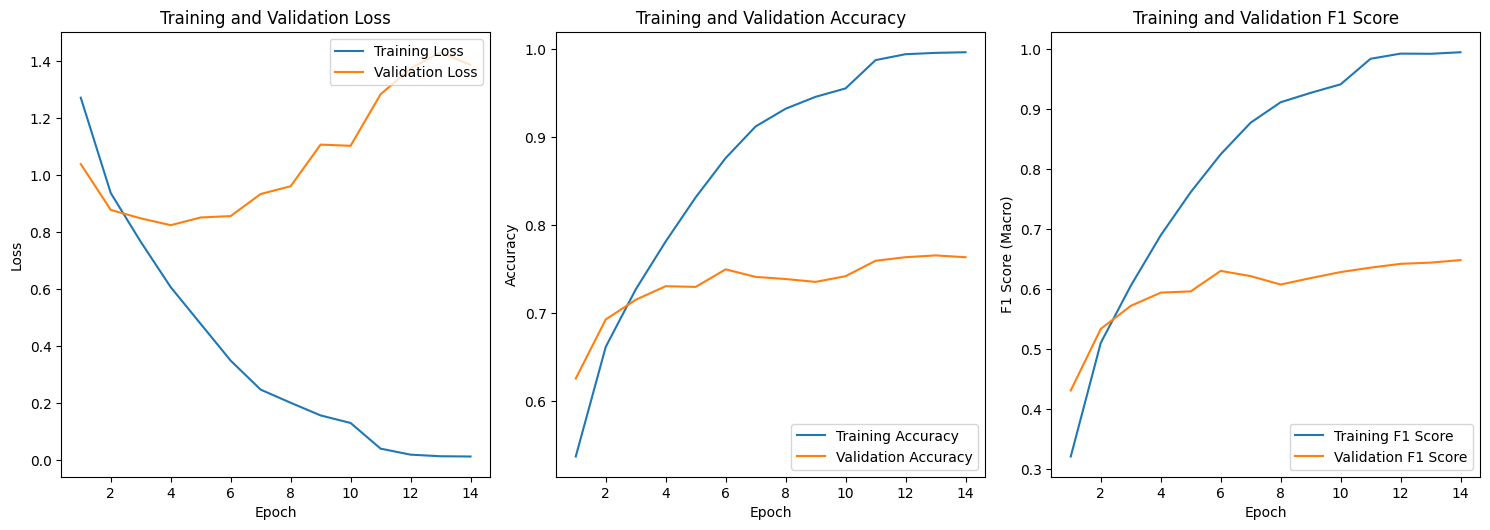

              precision    recall  f1-score   support

     alegria       0.97      0.98      0.98      4772
    disgusto       0.92      0.88      0.90       717
       enojo       0.94      0.92      0.93       705
       miedo       0.95      0.86      0.90       281
    seriedad       0.93      0.96      0.94      2524
    sorpresa       0.96      0.95      0.95      1290
    tristeza       0.94      0.93      0.94      1982

    accuracy                           0.95     12271
   macro avg       0.94      0.93      0.93     12271
weighted avg       0.95      0.95      0.95     12271



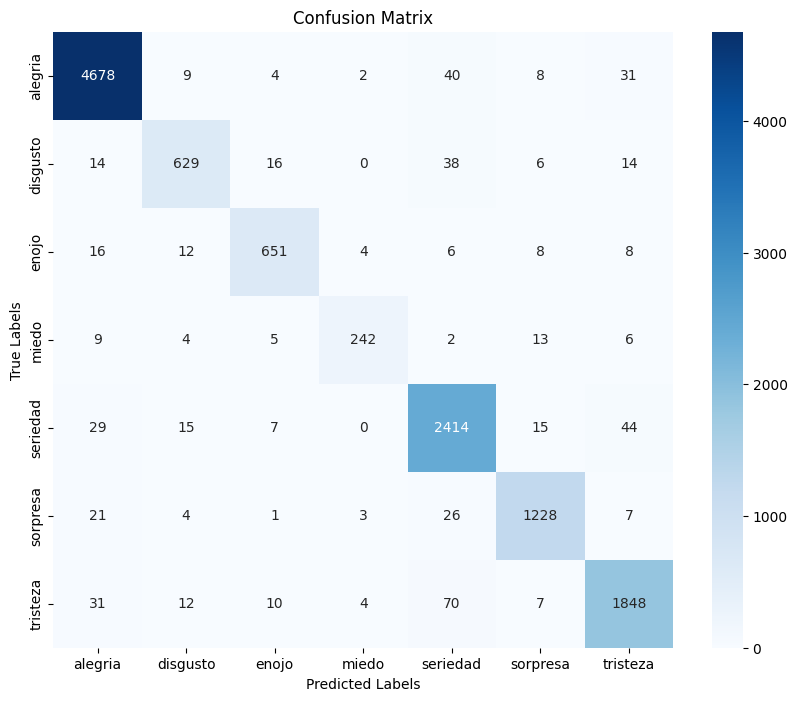

In [17]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPNCPNCPCFF",num_classes)
eval_model(model, root_directory, "CPNCPNCPCFF.pth")

In [31]:
torch.cuda.empty_cache()

## Training with validation patience

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.3109, Training Acc: 0.5289, Training F1: 0.3164
Epoch 1, Validation Loss: 1.0554, Validation Acc: 0.6216, Validation F1: 0.3981
Epoch 2, Training Loss: 0.9874, Training Acc: 0.6487, Training F1: 0.4964
Epoch 2, Validation Loss: 0.8639, Validation Acc: 0.6921, Validation F1: 0.5642
Epoch 3, Training Loss: 0.8090, Training Acc: 0.7148, Training F1: 0.6060
Epoch 3, Validation Loss: 0.8690, Validation Acc: 0.6957, Validation F1: 0.5451
Epoch 4, Training Loss: 0.6674, Training Acc: 0.7647, Training F1: 0.6834
Epoch 4, Validation Loss: 0.8829, Validation Acc: 0.6994, Validation F1: 0.5858
Early stopping triggered (Validation F1 < Training F1 for 2 consecutive epochs).
Model weights saved to CPCPFF-2.pth
Training history saved to CPCPFF-2_history.csv


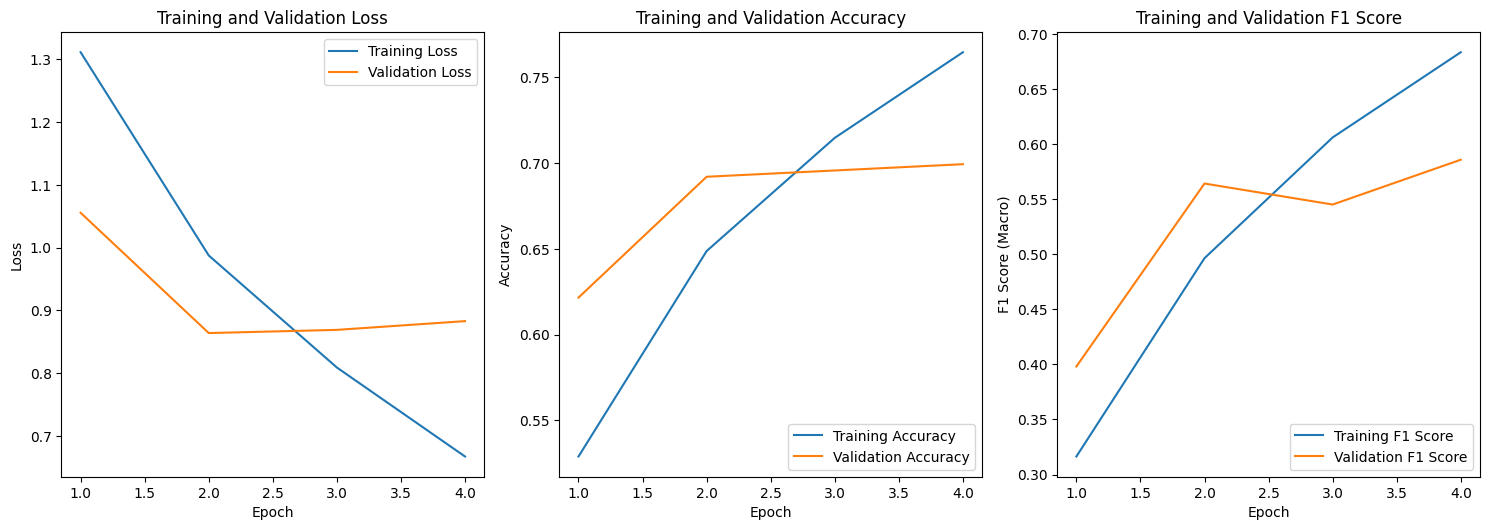

              precision    recall  f1-score   support

     alegria       0.92      0.91      0.91      4772
    disgusto       0.72      0.51      0.60       717
       enojo       0.83      0.74      0.78       705
       miedo       0.91      0.54      0.68       281
    seriedad       0.69      0.90      0.78      2524
    sorpresa       0.78      0.88      0.83      1290
    tristeza       0.86      0.63      0.73      1982

    accuracy                           0.82     12271
   macro avg       0.81      0.73      0.76     12271
weighted avg       0.83      0.82      0.82     12271



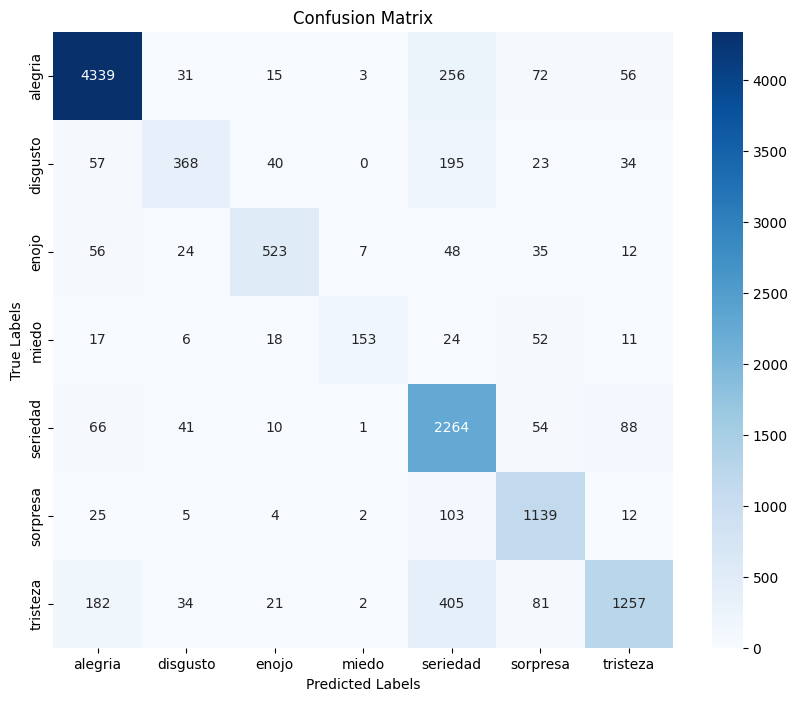

Epoch 3, Training Loss: 1.1620, Training Acc: 0.5824, Training F1: 0.3562


Epoch 3, Validation Loss: 1.0286, Validation Acc: 0.6395, Validation F1: 0.4231


Epoch 4, Training Loss: 0.9762, Training Acc: 0.6551, Training F1: 0.4562


Epoch 4, Validation Loss: 0.9210, Validation Acc: 0.6754, Validation F1: 0.4647


Epoch 5, Training Loss: 0.8453, Training Acc: 0.6993, Training F1: 0.5407


Epoch 5, Validation Loss: 0.8400, Validation Acc: 0.7055, Validation F1: 0.5575


Epoch 6, Training Loss: 0.7325, Training Acc: 0.7427, Training F1: 0.6021


Epoch 6, Validation Loss: 0.8033, Validation Acc: 0.7202, Validation F1: 0.5933


Epoch 7, Training Loss: 0.6266, Training Acc: 0.7797, Training F1: 0.6643


Epoch 7, Validation Loss: 0.8044, Validation Acc: 0.7271, Validation F1: 0.6122


Epoch 8, Training Loss: 0.5375, Training Acc: 0.8138, Training F1: 0.7143


Epoch 8, Validation Loss: 0.8266, Validation Acc: 0.7246, Validation F1: 0.6167


Epoch 9, Training Loss: 0.4391, Training Acc: 0.8480, Training F1: 0.7728


Epoch 9, Validation Loss: 0.8318, Validation Acc: 0.7312, Validation F1: 0.6225


Epoch 10, Training Loss: 0.3609, Training Acc: 0.8758, Training F1: 0.8243


Epoch 10, Validation Loss: 0.9327, Validation Acc: 0.7409, Validation F1: 0.6255


Epoch 11, Training Loss: 0.3006, Training Acc: 0.8972, Training F1: 0.8445


Epoch 11, Validation Loss: 0.9185, Validation Acc: 0.7251, Validation F1: 0.6081


Epoch 12, Training Loss: 0.2474, Training Acc: 0.9162, Training F1: 0.8787


Epoch 12, Validation Loss: 1.0636, Validation Acc: 0.7263, Validation F1: 0.6068


Epoch 13, Training Loss: 0.1161, Training Acc: 0.9624, Training F1: 0.9400


Epoch 13, Validation Loss: 1.1106, Validation Acc: 0.7523, Validation F1: 0.6544


Epoch 14, Training Loss: 0.0678, Training Acc: 0.9774, Training F1: 0.9604


Epoch 14, Validation Loss: 1.3356, Validation Acc: 0.7340, Validation F1: 0.6251


Epoch 15, Training Loss: 0.0549, Training Acc: 0.9813, Training F1: 0.9722


Epoch 15, Validation Loss: 1.4820, Validation Acc: 0.7446, Validation F1: 0.6477


Epoch 16, Training Loss: 0.0485, Training Acc: 0.9837, Training F1: 0.9748


Epoch 16, Validation Loss: 1.6191, Validation Acc: 0.7475, Validation F1: 0.6370
Early stopping triggered (validation loss did not improve for 10 epochs).


Model weights saved to PCCPCCPCFFF.pth
Training history saved to PCCPCCPCFFF_history.csv


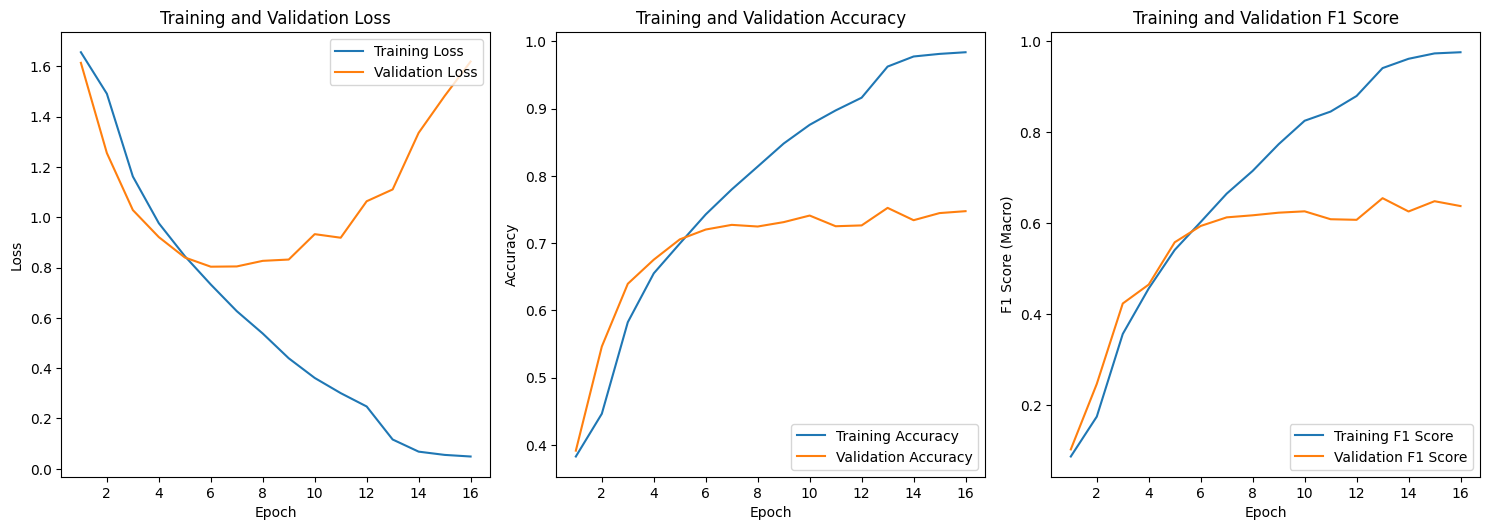

              precision    recall  f1-score   support

     alegria       0.98      0.98      0.98      4772
    disgusto       0.91      0.87      0.89       717
       enojo       0.97      0.90      0.93       705
       miedo       0.95      0.88      0.91       281
    seriedad       0.90      0.96      0.93      2524
    sorpresa       0.94      0.94      0.94      1290
    tristeza       0.95      0.92      0.94      1982

    accuracy                           0.95     12271
   macro avg       0.94      0.92      0.93     12271
weighted avg       0.95      0.95      0.95     12271



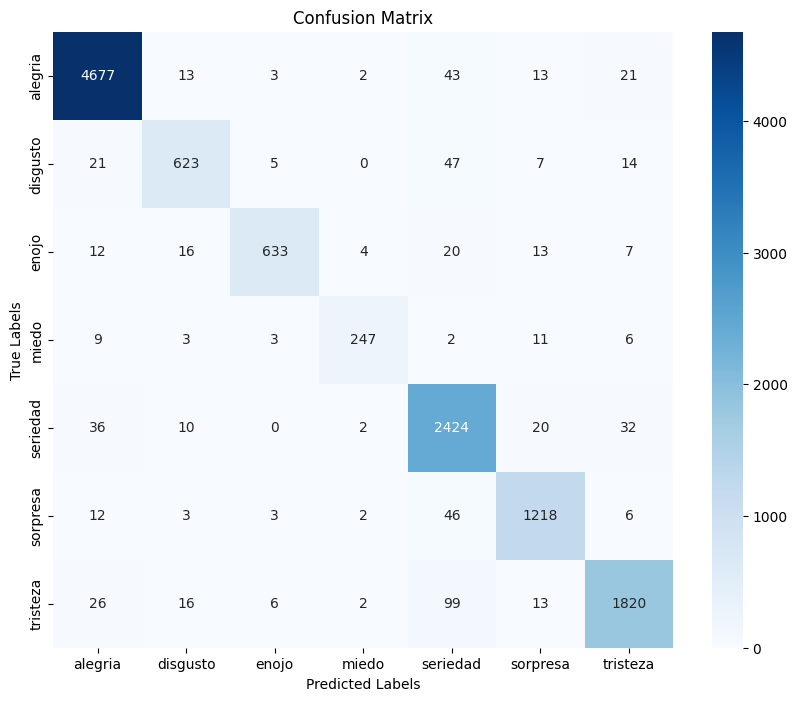

In [14]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPFF",num_classes)
eval_model(model, root_directory, save_path="CPCPFF-2.pth")
# eval_model(model, root_directory, save_path=None)

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.4165, Training Acc: 0.4813, Training F1: 0.2523
Epoch 1, Validation Loss: 1.1335, Validation Acc: 0.6086, Validation F1: 0.4034
Epoch 2, Training Loss: 1.0457, Training Acc: 0.6303, Training F1: 0.4661
Epoch 2, Validation Loss: 0.9217, Validation Acc: 0.6676, Validation F1: 0.4785
Epoch 3, Training Loss: 0.8674, Training Acc: 0.6930, Training F1: 0.5626
Epoch 3, Validation Loss: 0.8675, Validation Acc: 0.6912, Validation F1: 0.5522
Epoch 4, Training Loss: 0.7363, Training Acc: 0.7356, Training F1: 0.6268
Epoch 4, Validation Loss: 0.7575, Validation Acc: 0.7340, Validation F1: 0.6073
Early stopping triggered (Validation F1 < Training F1 for 2 consecutive epochs).
Model weights saved to CPCPCPFF-2.pth
Training history saved to CPCPCPFF-2_history.csv


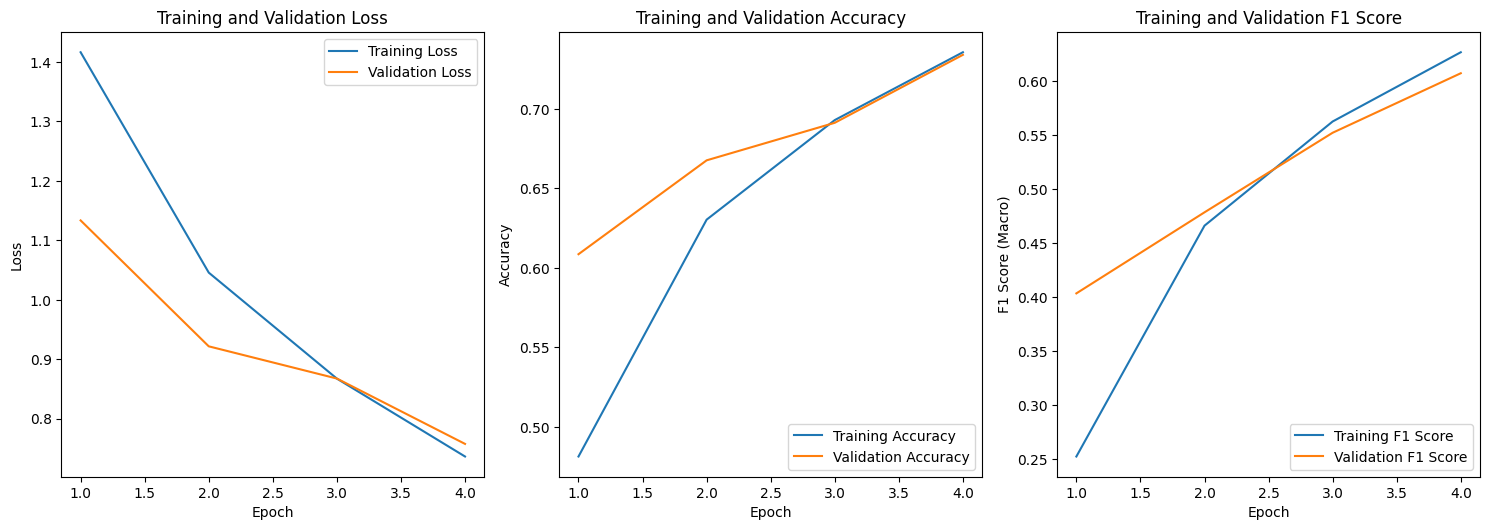

              precision    recall  f1-score   support

     alegria       0.89      0.94      0.91      4772
    disgusto       0.77      0.34      0.48       717
       enojo       0.74      0.71      0.73       705
       miedo       0.77      0.47      0.59       281
    seriedad       0.76      0.74      0.75      2524
    sorpresa       0.73      0.90      0.81      1290
    tristeza       0.73      0.75      0.74      1982

    accuracy                           0.80     12271
   macro avg       0.77      0.69      0.71     12271
weighted avg       0.80      0.80      0.80     12271



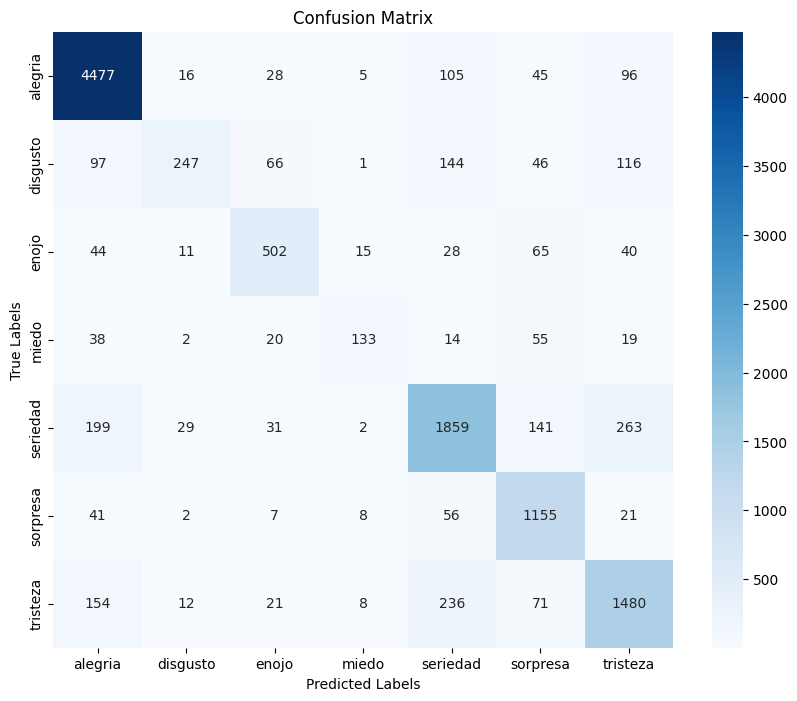

In [15]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPCPFF",num_classes)
eval_model(model, root_directory, save_path="CPCPCPFF-2.pth")
# eval_model(model, root_directory, save_path=None)

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.6464, Training Acc: 0.3887, Training F1: 0.0934
Epoch 1, Validation Loss: 1.5821, Validation Acc: 0.4037, Validation F1: 0.1285
Epoch 2, Training Loss: 1.4262, Training Acc: 0.4786, Training F1: 0.2191
Epoch 2, Validation Loss: 1.3551, Validation Acc: 0.5409, Validation F1: 0.3108
Epoch 3, Training Loss: 1.1549, Training Acc: 0.5822, Training F1: 0.3565
Epoch 3, Validation Loss: 1.0316, Validation Acc: 0.6277, Validation F1: 0.3850
Epoch 4, Training Loss: 0.9839, Training Acc: 0.6529, Training F1: 0.4688
Epoch 4, Validation Loss: 0.8780, Validation Acc: 0.6839, Validation F1: 0.4836
Epoch 5, Training Loss: 0.8355, Training Acc: 0.7058, Training F1: 0.5587
Epoch 5, Validation Loss: 0.8051, Validation Acc: 0.7177, Validation F1: 0.5751
Epoch 6, Training Loss: 0.7354, Training Acc: 0.7402, Training F1: 0.6163
Epoch 6, Validation Loss: 0.7550, Validation Acc: 0.7324, Validation F1: 0.6029
Epoch 7, Training Loss: 0.6314, Training Acc: 0.7784, Training F1: 0.6643
Ep

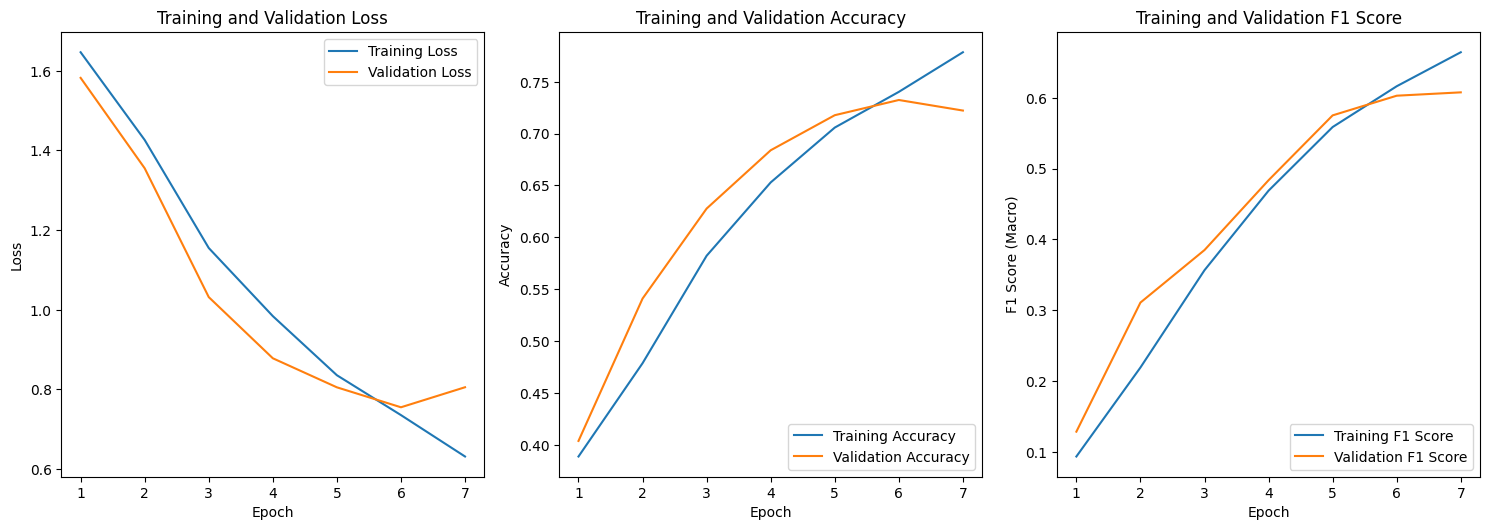

              precision    recall  f1-score   support

     alegria       0.93      0.95      0.94      4772
    disgusto       0.51      0.61      0.55       717
       enojo       0.83      0.74      0.79       705
       miedo       0.94      0.43      0.59       281
    seriedad       0.68      0.91      0.77      2524
    sorpresa       0.89      0.81      0.85      1290
    tristeza       0.92      0.56      0.69      1982

    accuracy                           0.82     12271
   macro avg       0.81      0.71      0.74     12271
weighted avg       0.84      0.82      0.82     12271



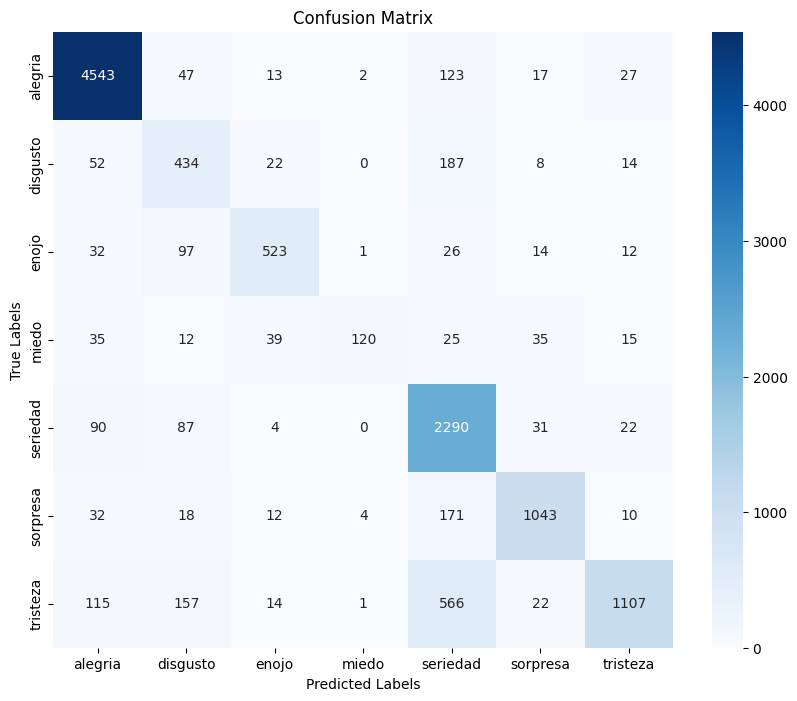

In [16]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("PCCPCCPCFFF",num_classes)
eval_model(model, root_directory, save_path="PCCPCCPCFFF-2.pth")
# eval_model(model, root_directory, save_path=None)

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.6535, Training Acc: 0.3846, Training F1: 0.0835
Epoch 1, Validation Loss: 1.5889, Validation Acc: 0.3890, Validation F1: 0.0800
Epoch 2, Training Loss: 1.5162, Training Acc: 0.4288, Training F1: 0.1590
Epoch 2, Validation Loss: 1.4192, Validation Acc: 0.4660, Validation F1: 0.2196
Epoch 3, Training Loss: 1.2792, Training Acc: 0.5345, Training F1: 0.2936
Epoch 3, Validation Loss: 1.1296, Validation Acc: 0.5910, Validation F1: 0.3636
Epoch 4, Training Loss: 1.1104, Training Acc: 0.5962, Training F1: 0.3958
Epoch 4, Validation Loss: 1.0405, Validation Acc: 0.6314, Validation F1: 0.4183
Epoch 5, Training Loss: 0.9869, Training Acc: 0.6458, Training F1: 0.4733
Epoch 5, Validation Loss: 0.9242, Validation Acc: 0.6570, Validation F1: 0.4945
Epoch 6, Training Loss: 0.8947, Training Acc: 0.6811, Training F1: 0.5250
Epoch 6, Validation Loss: 0.8436, Validation Acc: 0.6994, Validation F1: 0.5318
Epoch 7, Training Loss: 0.8115, Training Acc: 0.7138, Training F1: 0.5814
Ep

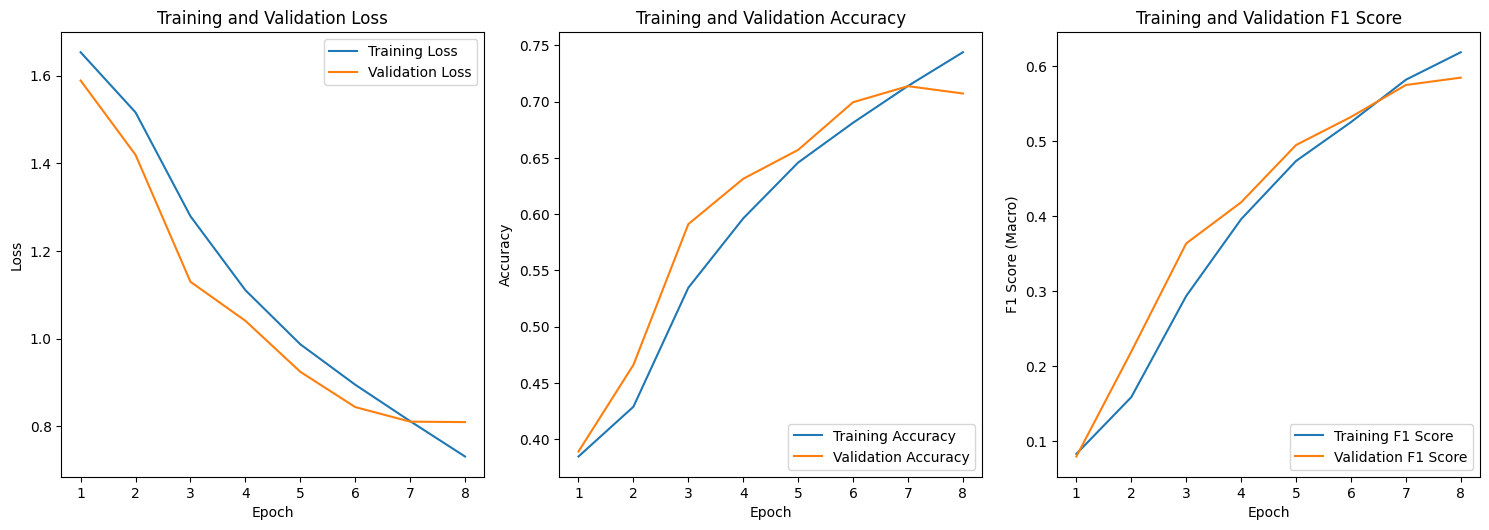

              precision    recall  f1-score   support

     alegria       0.92      0.92      0.92      4772
    disgusto       0.57      0.36      0.44       717
       enojo       0.66      0.77      0.71       705
       miedo       0.83      0.32      0.47       281
    seriedad       0.68      0.78      0.73      2524
    sorpresa       0.81      0.79      0.80      1290
    tristeza       0.65      0.66      0.66      1982

    accuracy                           0.78     12271
   macro avg       0.73      0.66      0.67     12271
weighted avg       0.78      0.78      0.77     12271



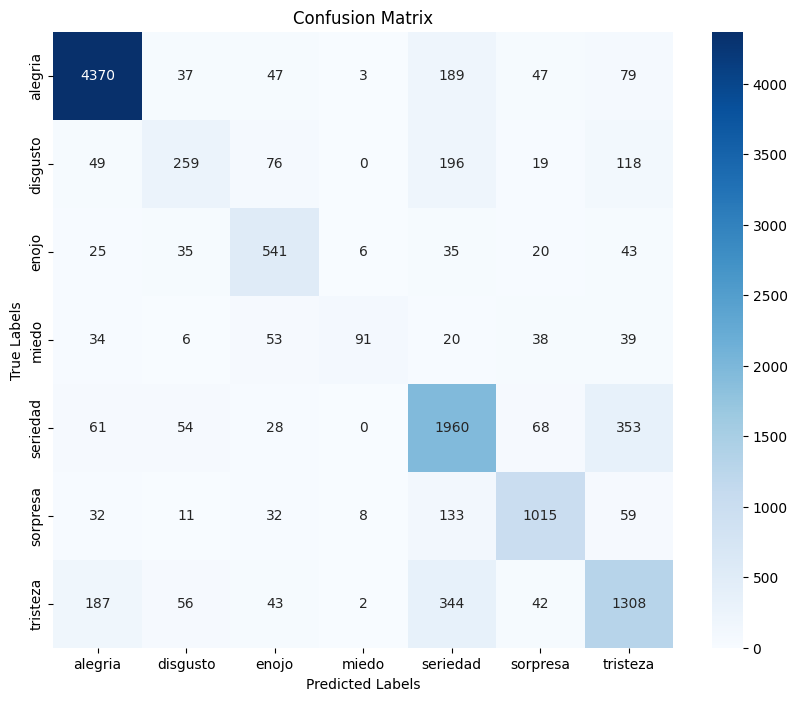

In [17]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPCPIIPIPFFF",num_classes)
eval_model(model, root_directory, save_path="CPCPIIPIPFFF-2.pth")
# eval_model(model, root_directory, save_path=None)

No weights file found. Training model...
Using 20% of training data for validation.


/home/leocenturion/Documents/postgrados/ia/deep-learning/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 1.3014, Training Acc: 0.5271, Training F1: 0.3087
Epoch 1, Validation Loss: 1.0529, Validation Acc: 0.6460, Validation F1: 0.4397
Epoch 2, Training Loss: 0.9549, Training Acc: 0.6592, Training F1: 0.4987
Epoch 2, Validation Loss: 0.8618, Validation Acc: 0.6900, Validation F1: 0.5578
Epoch 3, Training Loss: 0.7757, Training Acc: 0.7215, Training F1: 0.6024
Epoch 3, Validation Loss: 0.7627, Validation Acc: 0.7218, Validation F1: 0.5721
Epoch 4, Training Loss: 0.6398, Training Acc: 0.7650, Training F1: 0.6690
Epoch 4, Validation Loss: 0.7607, Validation Acc: 0.7405, Validation F1: 0.6171
Early stopping triggered (Validation F1 < Training F1 for 2 consecutive epochs).
Model weights saved to CPNCPNCPCFF-2.pth
Training history saved to CPNCPNCPCFF-2_history.csv


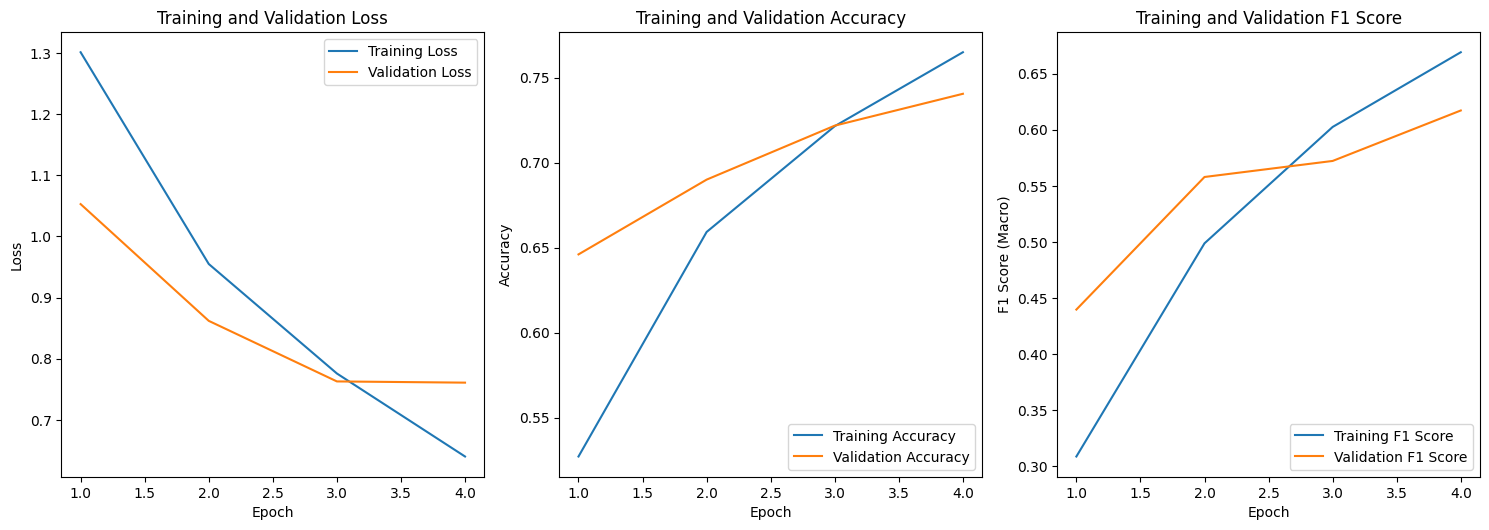

              precision    recall  f1-score   support

     alegria       0.90      0.96      0.93      4772
    disgusto       0.75      0.51      0.60       717
       enojo       0.86      0.71      0.78       705
       miedo       0.69      0.61      0.65       281
    seriedad       0.66      0.91      0.77      2524
    sorpresa       0.85      0.88      0.86      1290
    tristeza       0.93      0.50      0.65      1982

    accuracy                           0.82     12271
   macro avg       0.81      0.72      0.75     12271
weighted avg       0.83      0.82      0.81     12271



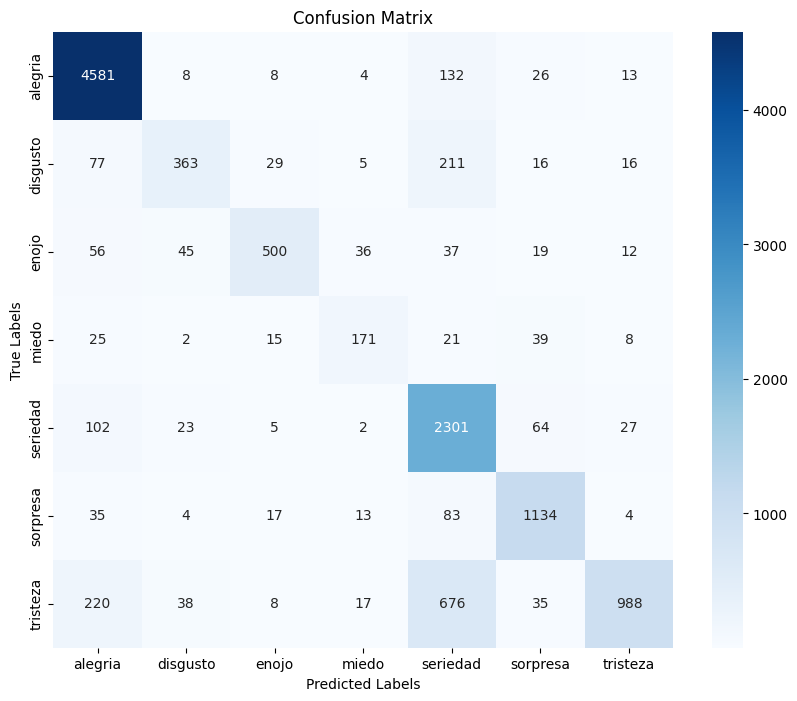

In [18]:
root_directory = './dataset_emociones'
num_classes = len(os.listdir(os.path.join(root_directory, 'train')))
model = ConfigurableCNNBuilder("CPNCPNCPCFF",num_classes)
eval_model(model, root_directory, save_path="CPNCPNCPCFF-2.pth")
# eval_model(model, root_directory, save_path=None)

In [23]:
ARCHITECTURES = [
        ('CPCPFF', 'CPCPFF.pth'),    
        ('CPCPCPFF', 'CPCPCPFF.pth'),
        ('PCCPCCPCFFF', 'PCCPCCPCFFF.pth'),
        ('CPCPIIPIPFFF', 'CPCPIIPIPFFF.pth'), 
        ('CPNCPNCPCFF', 'CPNCPNCPCFF.pth'),
]
IMAGE_FILES = ['happy.jpg', 'serious.jpg', 'triste.jpg']
DATA_ROOT = './dataset_emociones'
WEIGHTS_DIR = '.'


all_predictions = classify_images(
    model_configs=ARCHITECTURES,
    image_paths=IMAGE_FILES,
    root_directory=DATA_ROOT
)

# Optional: Print summary at the end
print("\n--- Classification Summary ---")
for img, preds in all_predictions.items():
    print(f"\nImage: {os.path.basename(img)}")
    for arch, pred_label in preds.items():
        print(f"  Architecture {arch}: {pred_label}")


--- Processing Architecture: CPCPFF (Weights: CPCPFF.pth) ---
Loading weights from CPCPFF.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: tristeza
Image: triste.jpg, Predicted Emotion: alegria

--- Processing Architecture: CPCPCPFF (Weights: CPCPCPFF.pth) ---
Loading weights from CPCPCPFF.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: tristeza
Image: triste.jpg, Predicted Emotion: tristeza

--- Processing Architecture: PCCPCCPCFFF (Weights: PCCPCCPCFFF.pth) ---
Loading weights from PCCPCCPCFFF.pth...
Image: happy.jpg, Predicted Emotion: seriedad
Image: serious.jpg, Predicted Emotion: tristeza
Image: triste.jpg, Predicted Emotion: tristeza

--- Processing Architecture: CPCPIIPIPFFF (Weights: CPCPIIPIPFFF.pth) ---
Loading weights from CPCPIIPIPFFF.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: seriedad
Image: triste.jpg, Predicted Emotion: miedo

--- Processing Ar

In [24]:
ARCHITECTURES = [
        ('CPCPFF', 'CPCPFF-2.pth'),    
        ('CPCPCPFF', 'CPCPCPFF-2.pth'),
        ('PCCPCCPCFFF', 'PCCPCCPCFFF-2.pth'),
        ('CPCPIIPIPFFF', 'CPCPIIPIPFFF-2.pth'), 
        ('CPNCPNCPCFF', 'CPNCPNCPCFF-2.pth'),
]
IMAGE_FILES = ['happy.jpg', 'serious.jpg', 'triste.jpg']
DATA_ROOT = './dataset_emociones'
WEIGHTS_DIR = '.'


all_predictions = classify_images(
    model_configs=ARCHITECTURES,
    image_paths=IMAGE_FILES,
    root_directory=DATA_ROOT
)

# Optional: Print summary at the end
print("\n--- Classification Summary ---")
for img, preds in all_predictions.items():
    print(f"\nImage: {os.path.basename(img)}")
    for arch, pred_label in preds.items():
        print(f"  Architecture {arch}: {pred_label}")


--- Processing Architecture: CPCPFF (Weights: CPCPFF-2.pth) ---
Loading weights from CPCPFF-2.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: seriedad
Image: triste.jpg, Predicted Emotion: sorpresa

--- Processing Architecture: CPCPCPFF (Weights: CPCPCPFF-2.pth) ---
Loading weights from CPCPCPFF-2.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: tristeza
Image: triste.jpg, Predicted Emotion: seriedad

--- Processing Architecture: PCCPCCPCFFF (Weights: PCCPCCPCFFF-2.pth) ---
Loading weights from PCCPCCPCFFF-2.pth...
Image: happy.jpg, Predicted Emotion: seriedad
Image: serious.jpg, Predicted Emotion: seriedad
Image: triste.jpg, Predicted Emotion: tristeza

--- Processing Architecture: CPCPIIPIPFFF (Weights: CPCPIIPIPFFF-2.pth) ---
Loading weights from CPCPIIPIPFFF-2.pth...
Image: happy.jpg, Predicted Emotion: enojo
Image: serious.jpg, Predicted Emotion: tristeza
Image: triste.jpg, Predicted Emotion: alegria